# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [88]:
# useful libraries to import
#collaborated with Mark
import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [127]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('/Users/allenchang/Desktop/qbio577_fall2023/data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('/Users/allenchang/Desktop/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/50/cg8yb2yx62q_k48p_3xp1yww0000gn/T/ipykernel_63885/1819684776.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('/Users/allenchang/Desktop/qbio577_fall2023/data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


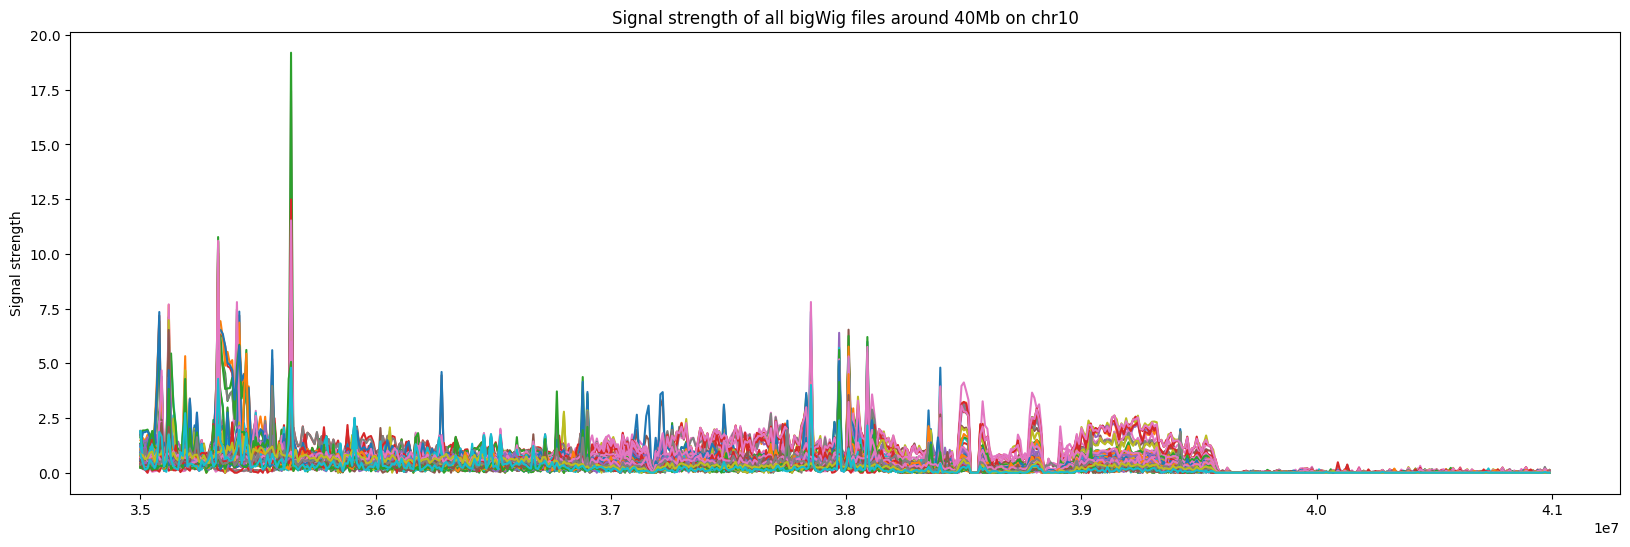

In [89]:
import matplotlib.pyplot as plt

# Filter data for around 40Mb
df_chr10 = df[(df['start'] >= 35_000_000) & (df['end'] <= 40_000_000 + 1_000_000)]

# Plot the signals for all bigWig files
plt.figure(figsize=(20,6))

for bw_file in df.columns[3:]:
    plt.plot(df_chr10['start'], df_chr10[bw_file], label=bw_file)

plt.xlabel('Position along chr10')
plt.ylabel('Signal strength')
plt.title('Signal strength of all bigWig files around 40Mb on chr10')
#plt.legend(loc='upper right')
plt.show()


A possible reason could be that there is a centromere located in this region of the chromosome. 

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


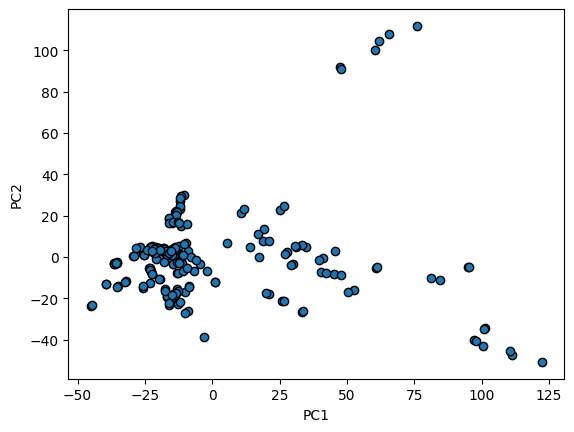

In [101]:
dfdrop = df.drop(['chrom', 'start', 'end'], axis = 1)
dft = dfdrop.transpose()
pca = sklearn.decomposition.PCA(n_components = 2)
pca_result = pca.fit_transform(dft)

pcadf = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])

plt.figure()
plt.scatter(pcadf['PC1'], pcadf['PC2'], edgecolor = 'k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

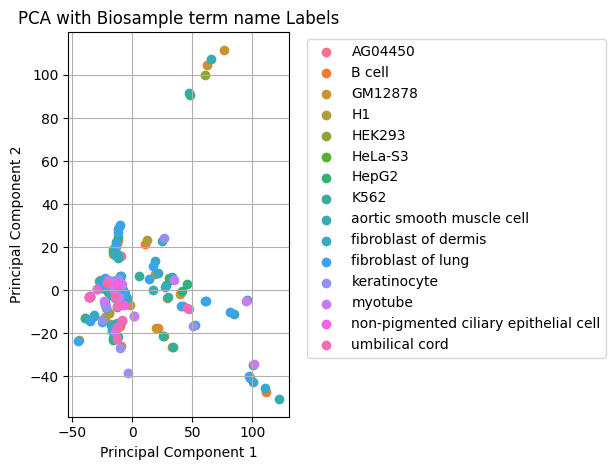

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
def visualize_pca_for_column(column_name):
    if column_name in bigwig_metadata.columns:
        # Select the same rows from aligned_metadata as in pca_df
        aligned_subset = bigwig_metadata.loc[pcadf.index, column_name]

        le = LabelEncoder()
        labels = le.fit_transform(aligned_subset)
        # Unique labels and their names
        unique_labels = np.unique(labels)
        label_names = le.inverse_transform(unique_labels)

        # Get a palette with as many colors as unique labels
        palette = sns.color_palette("husl", len(unique_labels))
        
        # Scatter plot for each category
        for i, label_name in zip(unique_labels, label_names):
            subset = pcadf[labels == i]
            plt.scatter(subset['PC1'], subset['PC2'], c=[palette[i]], label=label_name)
        
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA with {column_name} Labels')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{column_name}' column not found in the metadata.")

visualize_pca_for_column('Biosample term name')


The biosample term name represents the cell types, so they can be useful in outlier removal. 

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


I am not sure. According to the plot above, some types such as GM12878 appear very far away. 

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


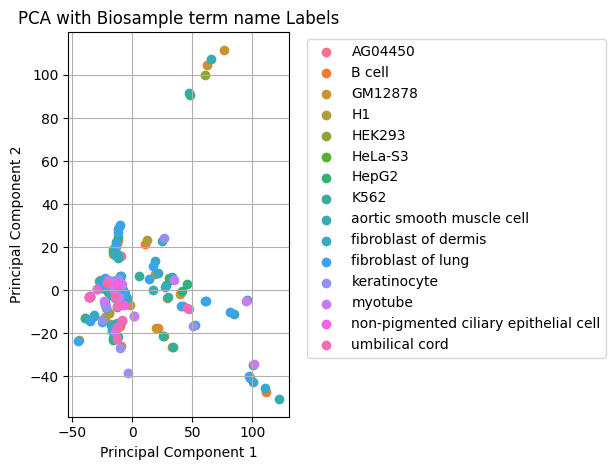

In [136]:
visualize_pca_for_column('Biosample term name')


I have a plot above, but it seems like some cell types on the upper right are further away in the PCA plot. 

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


I don't think that preprocessing matters too much, because there was not much preprocessing I did to my data. 

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


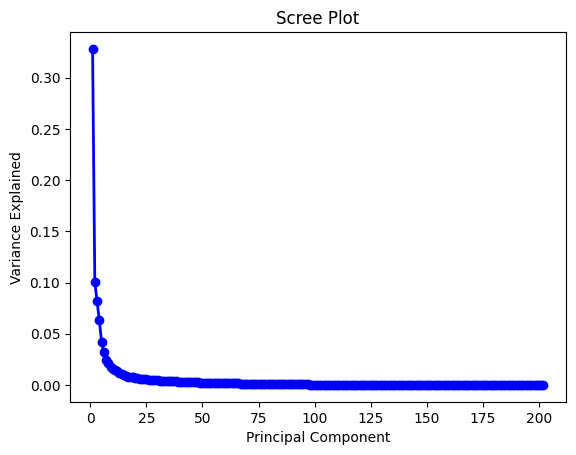

Number of components needed to explain at least 90% of the variance: 36


In [40]:
scaler = sklearn.preprocessing.StandardScaler()
#create copy of DataFrame
scaled_df=dfdrop.copy()
#created scaled version of DataFrame
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

# Perform PCA
pca = sklearn.decomposition.PCA()
pcafit = pca.fit(scaled_df)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find number of components needed to explain at least 90% variance
num_components = np.where(cumulative_explained_variance >= 0.9)[0][0] + 1

print(f"Number of components needed to explain at least 90% of the variance: {num_components}")


- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/Users/allenchang/opt/anaconda3/envs/qbio481/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


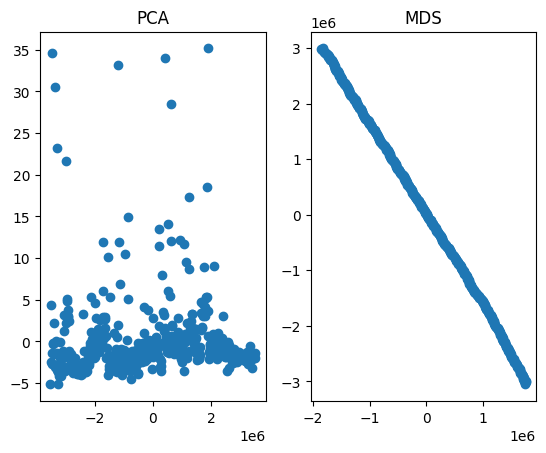

In [128]:
import sklearn.manifold
pca = sklearn.decomposition.PCA(n_components = 2)

df = df.drop(['chrom'], axis = 1)
dfdroppart = df[(df['start'] >= 10000000) & (df['end'] < 15000000)]
pca = sklearn.decomposition.PCA(n_components = 2)
dfPCA = pca.fit_transform(dfdroppart)

mds = sklearn.manifold.MDS(n_components = 2)
dfMDS = mds.fit_transform(dfdroppart)

fig, ax = plt.subplots(1, 2)

ax[0].scatter(dfPCA[:, 0], dfPCA[:, 1])
ax[0].set_title('PCA')

ax[1].scatter(dfMDS[:, 0], dfMDS[:, 1])
ax[1].set_title('MDS')

plt.show()

The MDS dimensionality reduction looks quite a bit cleaner. It seems like the correlations between the two dimensions are less noisy. 

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not? (No plots needed for this question).

This can work, because this dataset only has non-negative values, and it is generally an effective dimensionality reduction method. 